# Neural Prophet Forecasting model

Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from snowflake.snowpark import Session

import warnings

# Ignore only DeprecationWarnings
warnings.filterwarnings('ignore')

from neuralprophet import NeuralProphet

from utils import create_session, mape

Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


## Data Setup

In [2]:
session = create_session()

df = session.table("company_revenue_time_series_1") #with cutoff
df = df.to_pandas()

df = df.rename(columns={'DATE': 'ds', 'REVENUE': 'y'})
df = df[['ds', 'y']] # drop everything but these two if there are any

df['ds'] = pd.to_datetime(df['ds'])
df = df.sort_values(by='ds')
df = df.reset_index(drop=True)

print(df.head())
print(df.info())

# z-score = 2
mean = df['y'].mean()
std = df['y'].std()

z_scores = (df['y'] - mean) / std

threshold = 2
outlier_index = np.where(np.abs(z_scores) > threshold)[0]
print("Dropping "+str(len(outlier_index)) + " rows.")
df.drop(index=outlier_index,inplace=True)

cutoff = round(len(df)*0.8)
train = df[:cutoff]
test = df[cutoff:]

          ds          y
0 2012-03-02  137233.99
1 2012-03-03  190247.55
2 2012-03-04  197809.12
3 2012-03-05  125417.64
4 2012-03-06  120953.92
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364 entries, 0 to 363
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      364 non-null    datetime64[ns]
 1   y       364 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.8 KB
None
Dropping 12 rows.


## Simple Neural Prophet

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.582% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 170


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (18) is too small than the required number                     for the learning rate finder (214). The results might not be optimal.
Finding best initial lr: 100%|██████████| 214/214 [00:03<00:00, 56.36it/s]


Training: |          | 0/? [01:00<?, ?it/s, v_num=4, train_loss=0.0183, reg_loss=0.000, MAE=7.48e+3, RMSE=1.11e+4, Loss=0.0181, RegLoss=0.000]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 92.857% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 92.857% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.33it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


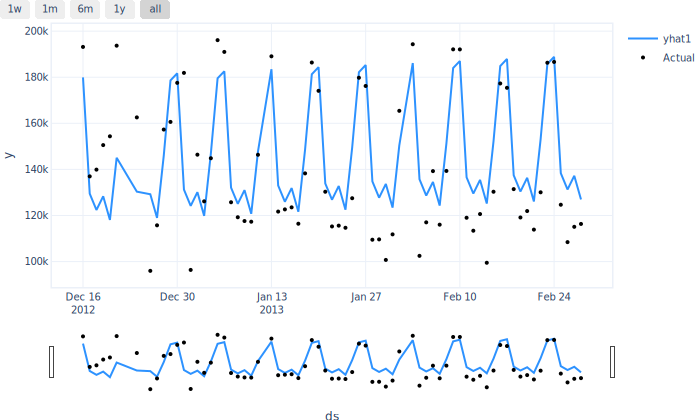

In [4]:

m = NeuralProphet()

m.set_plotting_backend("plotly-static")  # show plots correctly in jupyter notebooks
metrics = m.fit(train, freq='D')
b
forecast = m.predict(test)

m.plot(forecast)

In [5]:
nn_prophet_mape = mape(test['y'], forecast['yhat1'])
print(f'Neural Prophet MAPE: {nn_prophet_mape}%')

Neural Prophet MAPE: 10.78%


## Cross Validation

In [26]:
# setup

def cross_validation(params, df):
    folds = NeuralProphet(**params).crossvalidation_split_df(df, freq="D", k=5, fold_pct=0.20, fold_overlap_pct=0.5)


    tests = []
    forecasts = []

    for df_train, df_test in folds:
        m = NeuralProphet(**params)
        m.set_plotting_backend("plotly-static")
        train = m.fit(df=df_train, freq="D")
        forecast = m.predict(df_test)
        test = m.test(df=df_test)
        tests.append(test)
        forecasts.append(forecast)

    return tests, forecasts#, metrics_train, metrics_test


In [29]:
params = {"seasonality_mode": "multiplicative", "learning_rate": 0.1}
metrics, forecast = cross_validation(params, df)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 97.727% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.592% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 220


Training: |          | 0/? [00:50<?, ?it/s, v_num=26, train_loss=0.0184, reg_loss=0.000, MAE=6.76e+3, RMSE=1.04e+4, Loss=0.0187, RegLoss=0.000]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.571% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.571% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 29.02it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.571% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D



Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.11it/s]


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.02016439475119114
         MAE_val              6811.9150390625
        RMSE_val              9315.3505859375
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.87% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 200


Training: |          | 0/? [00:48<?, ?it/s, v_num=27, train_loss=0.0163, reg_loss=0.000, MAE=6e+3, RMSE=8.94e+3, Loss=0.0151, RegLoss=0.000]   

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.571% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.571% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.28it/s] 

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.571% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D



Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 38.61it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.057% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 190



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.023808812722563744
         MAE_val             7444.16845703125
        RMSE_val               10005.4140625
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Training: |          | 0/? [00:35<?, ?it/s, v_num=28, train_loss=0.0166, reg_loss=0.000, MAE=7.3e+3, RMSE=1.06e+4, Loss=0.020, RegLoss=0.000]  

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 95.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 95.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.09it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 95.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D



Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 36.68it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.19% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 180



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.04316285625100136
         MAE_val              9258.0634765625
        RMSE_val             14366.8310546875
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 190: 100%|██████████| 190/190 [00:00<00:00, 447.81it/s]   
Training: |          | 0/? [00:55<?, ?it/s, v_num=29, train_loss=0.014, reg_loss=0.000, MAE=5.99e+3, RMSE=9.36e+3, Loss=0.0136, RegLoss=0.000] 

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 91.429% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 91.429% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 42.03it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 91.429% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D



Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 25.86it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.06964022666215897
         MAE_val             12448.1552734375
        RMSE_val              19211.529296875
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.582% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 170


Training: |          | 0/? [01:22<?, ?it/s, v_num=30, train_loss=0.0168, reg_loss=0.000, MAE=6.86e+3, RMSE=1.02e+4, Loss=0.0165, RegLoss=0.000]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 92.857% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 92.857% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 39.11it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 92.857% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D



Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.88it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.05750052630901337
         MAE_val             13384.9267578125
        RMSE_val              17693.70703125
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [36]:
combined_forecast = pd.concat(forecast)
print(f"MAPE: {mape(combined_forecast['y'], combined_forecast['yhat1'])}%")

MAPE: 7.09%


## Trying other parameters

Add a parameter for day of month. 

### Data Setup

In [37]:
session = create_session()

df = session.table("company_revenue_time_series_1") #with cutoff
df = df.to_pandas()

df = df.rename(columns={'DATE': 'ds', 'REVENUE': 'y'})
df = df[['ds', 'y', 'day_of_month']] # drop everything but these two if there are any

df['ds'] = pd.to_datetime(df['ds'])
df = df.sort_values(by='ds')
df = df.reset_index(drop=True)

print(df.head())
print(df.info())

# z-score = 2
mean = df['y'].mean()
std = df['y'].std()

z_scores = (df['y'] - mean) / std

threshold = 2
outlier_index = np.where(np.abs(z_scores) > threshold)[0]
print("Dropping "+str(len(outlier_index)) + " rows.")
df.drop(index=outlier_index,inplace=True)

cutoff = round(len(df)*0.8)
train = df[:cutoff]
test = df[cutoff:]

          ds          y  day_of_month
0 2012-03-02  137233.99             2
1 2012-03-03  190247.55             3
2 2012-03-04  197809.12             4
3 2012-03-05  125417.64             5
4 2012-03-06  120953.92             6
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364 entries, 0 to 363
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   ds            364 non-null    datetime64[ns]
 1   y             364 non-null    float64       
 2   day_of_month  364 non-null    int8          
dtypes: datetime64[ns](1), float64(1), int8(1)
memory usage: 6.2 KB
None
Dropping 12 rows.


### Model fitting and forecast

In [38]:
params = {"weekly_seasonality":True, "learning_rate": 0.1}


m = NeuralProphet()
m.add_future_regressor('day_of_month')
m.set_plotting_backend("plotly-static")  # show plots correctly in jupyter notebooks
metrics = m.fit(train, freq='D')

forecast = m.predict(test)

m.plot(forecast)
print(f"MAPE: {mape(forecast['y'], forecast['yhat'])}")

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.582% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 170


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (18) is too small than the required number                     for the learning rate finder (214). The results might not be optimal.
Finding best initial lr: 100%|██████████| 214/214 [00:03<00:00, 63.48it/s]


Epoch 39:  23%|██▎       | 39/170 [00:00<00:00, 90274.75it/s]oss=0.0209, reg_loss=0.000, MAE=8.43e+3, RMSE=1.2e+4, Loss=0.0206, RegLoss=0.000] 